In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.ticker import MultipleLocator
import os.path
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from qbo1d import utils
from qbo1d import adsolver
from qbo1d import emulate
from qbo1d.stochastic_forcing import WaveSpectrum

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

from qbo1d.stochastic_forcing import sample_sf_cw

%load_ext autoreload
%autoreload 2

## Utils

In [2]:
def ax_pos_inch_to_absolute(fig_size, ax_pos_inch):
    ax_pos_absolute = []
    ax_pos_absolute.append(ax_pos_inch[0]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[1]/fig_size[1])
    ax_pos_absolute.append(ax_pos_inch[2]/fig_size[0])
    ax_pos_absolute.append(ax_pos_inch[3]/fig_size[1])
    
    return ax_pos_absolute

In [3]:
def plot_76_tensors(u, solver, amp25=None, amp20=None, period=None, isu=True):
    fig_size = (06.90, 02.20+01.50)
    fig = plt.figure(figsize=fig_size)

    ax = []

    ax.append(fig.add_axes(ax_pos_inch_to_absolute(fig_size, [00.75, 01.25, 06.00, 02.00])))

    cmin = -u.abs().max()
    cmax = u.abs().max()

    xmin = 84.
    xmax = 96.
    ymin = 17.
    ymax = 35.

    ax[0].set_xlim(left=84.)
    ax[0].set_xlim(right=96.)
    ax[0].set_ylim(bottom=17.)
    ax[0].set_ylim(top=35.)

    h = []

    h.append(ax[0].contourf(solver.time/86400/360, solver.z/1000, u.T,
                21, cmap="RdYlBu_r", vmin=cmin, vmax=cmax))

    ax[0].axhline(25., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)
    ax[0].axhline(20., xmin=0, xmax=1, color='white', linestyle='dashed', linewidth=1.)

    ax[0].set_ylabel('Km', fontsize=10)

    ax[0].set_xlabel('model year', fontsize=10)

    xticks_list = np.arange(xmin, xmax+1, 1)
    ax[0].set_xticks(xticks_list)

    yticks_list = np.arange(ymin, ymax+2, 2)
    ax[0].set_yticks(yticks_list)

    xticklabels_list = list(xticks_list)
    xticklabels_list = [ '%.0f' % elem for elem in xticklabels_list ]
    ax[0].set_xticklabels(xticklabels_list, fontsize=10)

    ax[0].xaxis.set_minor_locator(MultipleLocator(1.))
    ax[0].yaxis.set_minor_locator(MultipleLocator(1.))

    ax[0].tick_params(which='both', left=True, right=True, bottom=True, top=True)
    ax[0].tick_params(which='both', labelbottom=True)

    if isu:
        ax[0].text(95.50, 25, r'$\sigma_{25}$ = ' '%.1f' %amp25 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(95.50, 20, r'$\sigma_{20}$ = ' '%.1f' %amp20 + r'$\mathrm{m s^{-1}}$',
        horizontalalignment='right', verticalalignment='bottom', color='black')

        ax[0].text(84.50, 25, r'$\tau_{25}$ = ' '%.0f' %period + 'months',
        horizontalalignment='left', verticalalignment='bottom', color='black')

    # # colorbars
    if isu:
        label = r'$\mathrm{m s^{-1}}$'
    else:
        label = r'$\mathrm{m s^{-2}}$'
    
    cbar_ax0 = fig.add_axes(ax_pos_inch_to_absolute(fig_size, [01.00, 00.50, 05.50, 00.10])) 
    ax[0].figure.colorbar(plt.cm.ScalarMappable(cmap="RdYlBu_r"), cax=cbar_ax0, format='% 2.0f', 
    boundaries=np.linspace(cmin, cmax, 21), orientation='horizontal',
    label=label)


In [4]:
def rMSE(s_gt, s_pred):
    error = (s_gt - s_pred)
    SSE = sum(error ** 2)
    MSE = SSE/s_gt.shape[0]
    RMSE = MSE**.5
    return RMSE

def plot_MSE(RMSE_list):
    levels = list(range(len(RMSE_list[0])))
    for RMSE in RMSE_list:
        plt.scatter(x=RMSE, y=levels, s=2)
        plt.plot(RMSE, levels)
    plt.show()

# Solve the PDE using WaveSpectrum as the source function

In [5]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)




In [6]:
# calculate amplitude and period
spinup_time = 12*360*86400

amp25 = utils.estimate_amplitude(solver.time, solver.z, u, height=25e3, spinup=spinup_time)
amp20 = utils.estimate_amplitude(solver.time, solver.z, u, height=20e3, spinup=spinup_time)
tau25 = utils.estimate_period(solver.time, solver.z, u, height=25e3, spinup=spinup_time)


## Visualization(Ground Truth)

### u(zonal wind)

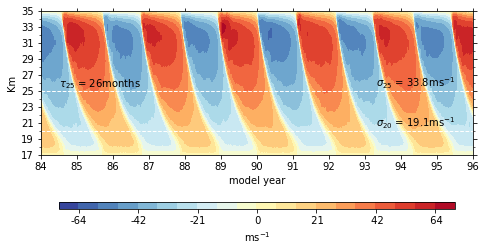

In [7]:
plot_76_tensors(u, solver=solver, amp25=amp25, amp20=amp20, period=tau25, isu=True)

### s (source function)

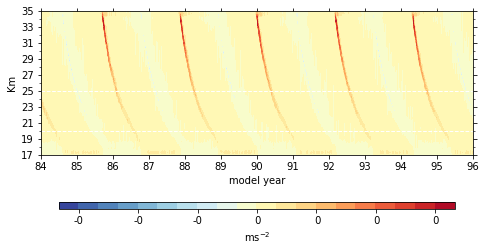

In [8]:
plot_76_tensors(model.s, solver, isu=False)

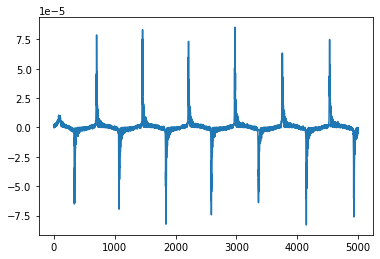

In [9]:
s_35 = model.s[:, 35]
plt.plot(list(range(len(s_35)))[:5000], s_35[:5000])

## Prepare for the data

### Here we only use $u$ without concatnating $sf$ and $cw$

In [10]:
U = u[nspinup:nsteps, :]
s = model.s
s = s[nspinup:nsteps, :]

# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

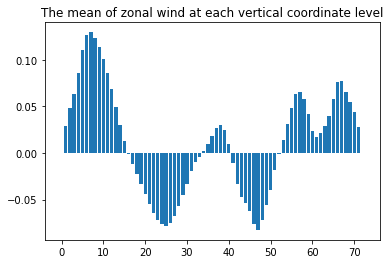

In [11]:
mean = U_train.mean(axis=0)
std = U_train.std(axis=0)
plt.bar(list(range(len(mean))), mean)
plt.title("The mean of zonal wind at each vertical coordinate level")
plt.show()
# This plot makes a lot of sense...
# Really makes sense...


# Linear Regression on $u$ (By sklearn)

In [12]:
reg = LinearRegression().fit(U_train, s_train)
prediction = reg.predict(U_test)
mean_l2_loss = np.linalg.norm((prediction - s_test.numpy()), axis=1).mean()
print(f"The loss of the linear regression: {mean_l2_loss}")
print(f"R-squared: {reg.score(U_test, s_test):.9f}")

The loss of the linear regression: 2.771425839605591e-05
R-squared: 0.895522434


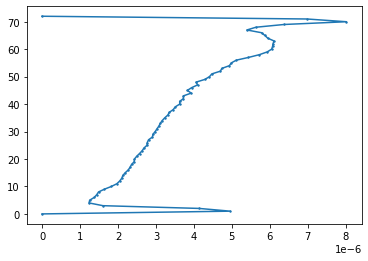

In [13]:
s_pred = torch.tensor(reg.predict(U))
rmse_1 = rMSE(s_pred, s)
plot_MSE([rmse_1])

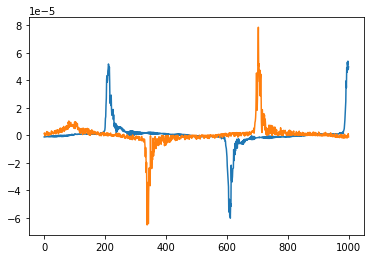

In [14]:
s_pred = torch.tensor(reg.predict(U))
s_pred_35 = s_pred[:, 35]
plt.plot(list(range(len(s_pred_35)))[:1000], s_pred_35[:1000])
plt.plot(list(range(len(s_35)))[:1000], s_35[:1000])

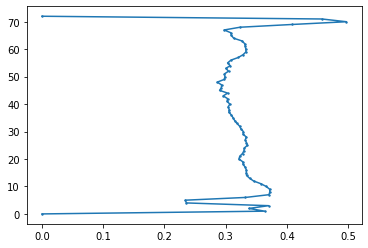

In [15]:
rmse_trial = rMSE(s_pred, s)
s_std = s.std(axis=0) + 1e-32
plot_MSE([rmse_trial/s_std])

## ONLINE testing

In [16]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE
model_ML = lambda x : torch.tensor(reg.coef_) @ x + torch.tensor(reg.intercept_)


u_ML = solver_ML.solve(source_func=model_ML)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [17]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

### Visualization(ML)

### $u_{ML}$(zonal wind)


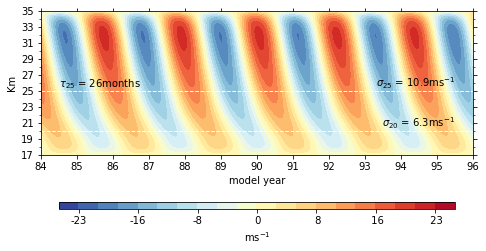

In [18]:
plot_76_tensors(u_ML, solver_ML, amp25=amp25_ML, amp20=amp20_ML, period=tau25_ML)

* The period is miraculously CORRECT... 
* The amplitude is not correct

Text(0.5, 1.0, '$u_{z = 35}$ for $sfv = 1e-8$(Linear model based on $u$)')

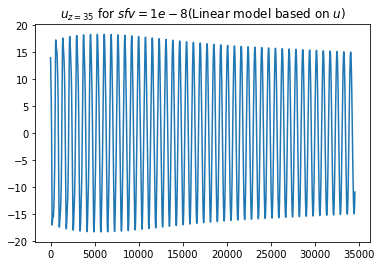

In [22]:
u_35 = u_ML[:, 35]
plt.plot(list(range(len(u_35))), u_35)
plt.title(r'$u_{z = 35}$ for $sfv = 1e-8$(Linear model based on $u$)')


### $s_{ML}$ (Source function)

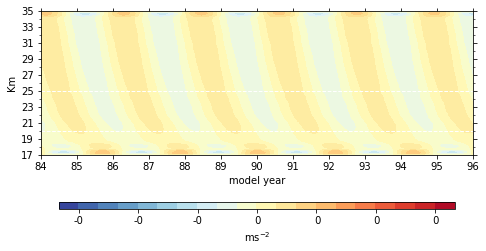

In [20]:
s_ML = torch.tensor(reg.predict(u_ML))
plot_76_tensors(s_ML, solver_ML, isu=False)

In [23]:
s_ML_35 = s_ML[:, 35]
plt.plot(list(range(len(s_35)))[:5000], s_35[:5000])

NameError: name 's_ML' is not defined

# Linear Regression on $(u, sf, cw)$

## Prepare for the data

In [24]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)
cw, sf = model.cw, model.sf


In [25]:
cw = cw[nspinup:nsteps]
sf = sf[nspinup:nsteps]
u = u[nspinup:nsteps, :]

s = model.s
s = s[nspinup:nsteps, :]

U = torch.hstack([u, sf.view(-1, 1), cw.view(-1, 1)])
print(f"The shape of data U is {U.shape}")


# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

The shape of data U is torch.Size([34560, 75])


In [26]:
# Though it may be clear to do the linear regression manually
# But the runtime of sklearn is optimal
reg = LinearRegression().fit(U_train, s_train)
prediction = reg.predict(U_test)
mean_l2_loss = np.linalg.norm((prediction - s_test.numpy()), axis=1).mean()
print(f"The loss of the linear regression: {mean_l2_loss}")
print(f"R-squared: {reg.score(U_test, s_test):.9f}")

The loss of the linear regression: 2.7714682118620877e-05
R-squared: 0.895525856


The loss and R-squared is similar to $U = u$

In [27]:
s_mean = s.mean(axis=0)
s_std = s.std(axis=0) + 1e-32

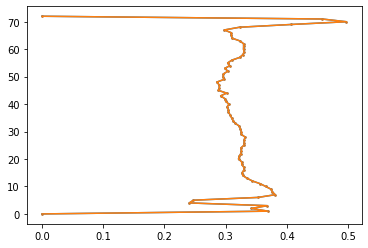

In [ ]:
s_pred = torch.tensor(reg.predict(U))
rmse_2 = rMSE(s_pred, s)
# after normalization
plot_MSE([(rmse_1)/s_std, (rmse_2)/s_std])

## ONLINE testing

In [28]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)

# Set up the linear model to pass in the PDE

sf_ML, cw_ML = sample_sf_cw(solver_ML.time.shape[0], sfe=3.7e-3, sfv=1e-8, cwe=32, cwv=225, corr=0.75, seed=int(21*9+8))

model_ML_aug = lambda x : torch.tensor(reg.coef_) @ torch.hstack([x, sf[solver_ML.current_step], cw[solver_ML.current_step]]) + torch.tensor(reg.intercept_)


u_ML = solver_ML.solve(source_func=model_ML_aug)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [29]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

In [30]:
# we need to calculate s_ML for further visualization
# this step is not that trivial this time
U_ML = torch.hstack([u_ML, sf_ML.view(-1, 1), cw_ML.view(-1, 1)])
s_ML = torch.tensor(reg.predict(U_ML))

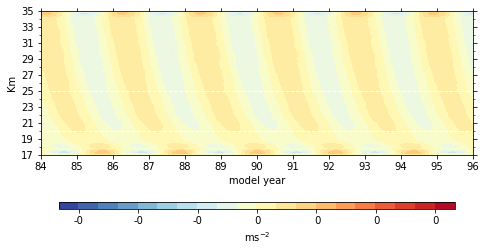

In [31]:
plot_76_tensors(s_ML, solver_ML, isu=False)

Text(0.5, 1.0, '$u_{z = 35}$ for $sfv = 1e-8$(Linear model based on $(u, cw, sf)$)')

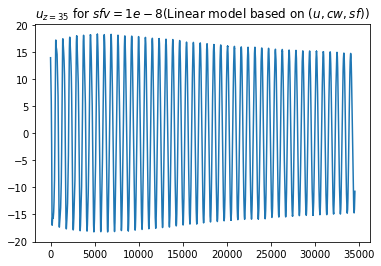

In [33]:
u_35 = u_ML[:, 35]
plt.plot(list(range(len(u_35))), u_35)
plt.title(r'$u_{z = 35}$ for $sfv = 1e-8$(Linear model based on $(u, cw, sf)$)')

# Try normalization

I tried but it doesn't work well

In [ ]:
# Load the data manually
# it takes 40 seconds

t_max = 360 * 108 * 86400
nsteps = 360 * 108
nspinup = 360 * 12
ntot = int(nsteps - nspinup)

torch.set_default_dtype(torch.float64)


# scenario 0 (control)
# --------------------
solver = adsolver.ADSolver(t_max=t_max, w=3e-4)
model = WaveSpectrum(solver)
time = solver.time
z = solver.z
u = solver.solve(source_func=model)

In [ ]:
U = u[nspinup:nsteps, :]
s = model.s
s = s[nspinup:nsteps, :]

# Here U is the features and s is the label

U_train, U_test, s_train, s_test = train_test_split(U, s, test_size=0.2, random_state=42)

In [ ]:
mean_U_train = U_train.mean(axis=0)
std_U_train = U_train.std(axis=0) + 1e-32 # avoid dividing by 0
normalized_U_train = (U_train - mean_U_train)/std_U_train
normalized_U_test = (U_test - mean_U_train)/std_U_train

In [ ]:
reg = Ridge(alpha=1).fit(normalized_U_train, s_train)
prediction = reg.predict(normalized_U_test)
mean_l2_loss = np.linalg.norm((prediction - s_test.numpy()), axis=1).mean()
print(f"THe loss of the linear regression: {mean_l2_loss}")
print(f"R-squared: {reg.score(normalized_U_test, s_test):.3f}")

THe loss of the linear regression: 2.7935106249965368e-05
R-squared: 0.894


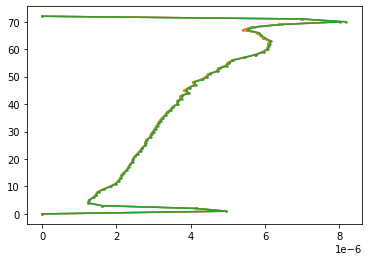

In [ ]:
normalized_U = (U - mean_U_train) / std_U_train
s_pred = torch.tensor(reg.predict(normalized_U))
rmse_3 = rMSE(s_pred, s)
plot_MSE([rmse_1, rmse_2, rmse_3])

## Online Testing

In [ ]:
torch.set_default_dtype(torch.float64)
solver_ML = adsolver.ADSolver(t_max=360*96*86400, w=3e-4)


def model_ML_norm(x):
    """
    Input: x, expected (73,) tensor
    Output: s, expected(73,) tensor
    """

    normed_x = (x - mean_U_train)/std_U_train
    
    return torch.tensor(reg.coef_) @ normed_x + torch.tensor(reg.intercept_)
    


u_ML = solver_ML.solve(source_func=model_ML_norm)
u_ML = u_ML.detach()

print("The UN - truncated u has length: ", len(u_ML))
nan_boolean = torch.tensor([not u_ML[i].isnan().any() for i in range(len(u_ML))]) # Boolean array to detect where u blows up
u_ML = u_ML[nan_boolean]
print("The truncated u has length: ", len(u_ML))

The UN - truncated u has length:  34561
The truncated u has length:  34561


In [ ]:
spinup_time = 12*360*86400

amp25_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)
amp20_ML = utils.estimate_amplitude(solver_ML.time, solver_ML.z, u_ML, height=20e3, spinup=spinup_time)
tau25_ML = utils.estimate_period(solver_ML.time, solver_ML.z, u_ML, height=25e3, spinup=spinup_time)

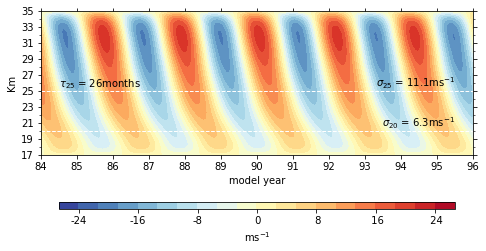

In [ ]:
plot_76_tensors(u_ML, solver_ML, amp20=amp20_ML, amp25=amp25_ML, period=tau25_ML)